In [1]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U

In [2]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [ ]:
sysparams = open("../system_params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [4]:
# Construct modes matrtix using system parameters
const modes = Seq.Modes()
const modes2 = Seq.Modes()
const nions = 13
const ion1 = 5
const ion2 = 9
for i in 1:nions
    push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
    push!(modes2, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
end
for i in 1:nions
    push!(modes2, 2π * (sysparams.modes.radial1[i] + 0.3), 0)
end

In [5]:
const blackman_start_end = U.BlackmanStartEnd{0.7}()

(::MSSim.Utils.BlackmanStartEnd{0.7}) (generic function with 1 method)

In [6]:
const nseg = 120
const buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
const buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

In [7]:
function _objfunc(vals)
    dis = sum(vals[i] for i in 1:13)
    dis′ = sum(vals[13 + i] for i in 1:13)
    disδ = sum(vals[13 * 2 + i] for i in 1:13)
    area = vals[1 + 13 * 3]
    areaδ = vals[2 + 13 * 3]
    τ = vals[3 + 13 * 3]

    return 5 * dis + dis′ / 10 + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

In [8]:
const nlmodel = Seq.Objective(SL.pmask_full,
                              (ntuple(i->(:dis2, i), 26)..., ntuple(i->(:disδ2, i), 13)...,
                               (:area, 0), (:areaδ, 0), (:τ, 0)),
                              objfunc, modes2, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end));

In [9]:
pitime_to_Ω(time) = π / (2 * time)
const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
Opts.set_bound!(tracker, nlmodel.param.τ, 0.1, 2.5)
Opts.set_bound!(tracker, nlmodel.param.Ωs[1], pitime_to_Ω(8), pitime_to_Ω(3.8))
for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, 2π * 2.29, 2π * 2.50)
end

In [10]:
# const opt = NLopt.Opt(:LD_SLSQP, nargs)
const opt = NLopt.Opt(:LD_LBFGS, nargs)
# NLopt.xtol_rel!(opt, 1e-5)
# NLopt.ftol_rel!(opt, 1e-5)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 15)

In [11]:
best_obj = 10.0
best_params = nothing
@time for i in 1:200
    global best_obj, best_params
    obj, params, ret = @time NLopt.optimize(opt, Opts.init_vars!(tracker))
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = sum(nlmodel(Val((:dis2, i)), params) for i in 1:13),
            disδ = sum(nlmodel(Val((:disδ2, i)), params) for i in 1:13),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωs[1]],
        )
        println(best_status)
        best_params = params
    end
end

  0.959372 seconds (2.42 M allocations: 120.189 MiB, 2.07% gc time, 93.14% compilation time)
  2.000973 seconds (10.38 k allocations: 143.499 MiB, 0.82% gc time)
  0.028790 seconds (174 allocations: 2.150 MiB, 1.17% gc time)
  0.904738 seconds (4.56 k allocations: 62.973 MiB, 0.54% gc time)
  0.029151 seconds (174 allocations: 2.192 MiB, 1.05% gc time)
  0.931503 seconds (4.90 k allocations: 67.684 MiB, 0.31% gc time)
  0.029444 seconds (175 allocations: 2.205 MiB, 1.13% gc time)
  0.662456 seconds (3.41 k allocations: 47.054 MiB, 0.33% gc time)
  0.866224 seconds (4.51 k allocations: 62.253 MiB, 0.32% gc time)
  0.029615 seconds (178 allocations: 2.247 MiB)
  1.254697 seconds (6.57 k allocations: 90.850 MiB, 0.30% gc time)
  3.050106 seconds (16.43 k allocations: 227.377 MiB, 0.35% gc time)
  0.030811 seconds (184 allocations: 2.330 MiB)
  1.559677 seconds (8.25 k allocations: 114.057 MiB, 0.39% gc time)
 15.000391 seconds (89.14 k allocations: 1.206 GiB, 0.37% gc time)
  2.789271 sec

In [12]:
opt_raw_params = Seq.RawParams(nlmodel, best_params)
println(opt_raw_params)

MSSim.Sequence.RawParams([2.094866243081788, -5.7366258190931444e-18, 0.0005468900984188242, 0.0, 15.088772246915457, 2.094866243081788, 0.0011456616058532659, 0.001709953215668464, 31.608959629612535, 15.276431858684429, 2.094866243081788, 0.004727784874606284, 0.003068399172071588, 63.61104104510972, 14.89484092707959, 2.094866243081788, 0.01115567072047916, 0.004712558555715601, 94.8137404993218, 15.125546403988805, 2.094866243081788, 0.021027850557394038, 0.006678374315026119, 126.49973706920507, 15.13459702905527, 2.094866243081788, 0.03501815146860671, 0.008935948854861871, 158.20469348801888, 14.946955339419366, 2.094866243081788, 0.05373776907456221, 0.011386854193263215, 189.5165656654196, 14.86983508272492, 2.094866243081788, 0.07759170553892362, 0.013870720912427779, 220.6668812204133, 15.007143293730639, 2.094866243081788, 0.1066490105455772, 0.016180471697925337, 252.10483911154085, 15.176035988409957, 2.094866243081788, 0.14054493450270125, 0.018084486937907693, 283.89660

In [13]:
kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

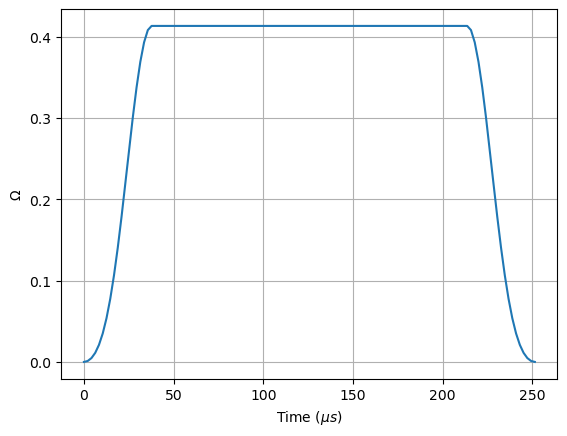

In [14]:
clf()
plot(Seq.get_Ωs(opt_raw_params)...)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\Omega$")
grid()
# display(gcf())

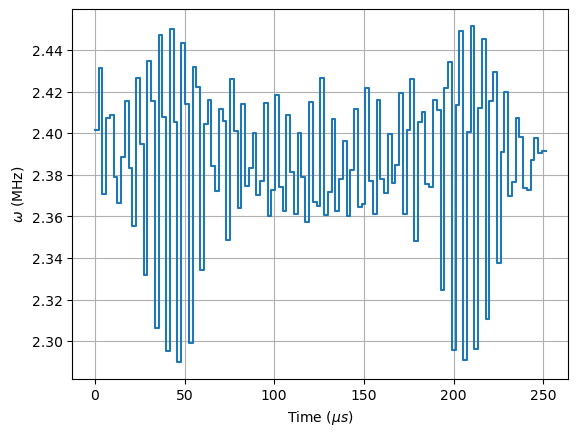

In [15]:
clf()
ts, ωs = Seq.get_ωs(opt_raw_params)
plot(ts, ωs ./ 2π)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\omega$ (MHz)")
grid()
# display(gcf())

In [16]:
println("Total displacement:")
println(Seq.total_dis(kern, opt_raw_params, modes))
println("cumulative displacement:")
println(Seq.total_cumdis(kern, opt_raw_params, modes))
println("Gradient of displacement w.r.t. detuning (disδ)")
println(Seq.total_disδ(kern, opt_raw_params, modes))
enclosed_area = Seq.total_area(kern, opt_raw_params, modes)
println("Enclosed area (area)")
println(enclosed_area)
println("Gradient of enclosed area w.r.t. detuning (areaδ)")
println(Seq.total_areaδ(kern, opt_raw_params, modes))

Total displacement:
1.8621575818448262e-8
cumulative displacement:
0.0012106566368701472
Gradient of displacement w.r.t. detuning (disδ)
2.5303818382539567e-7
Enclosed area (area)
1.5707980406914055
Gradient of enclosed area w.r.t. detuning (areaδ)
-57.25308518183796


In [17]:
plot_δs = range(-1, 1, 10001); # kHz

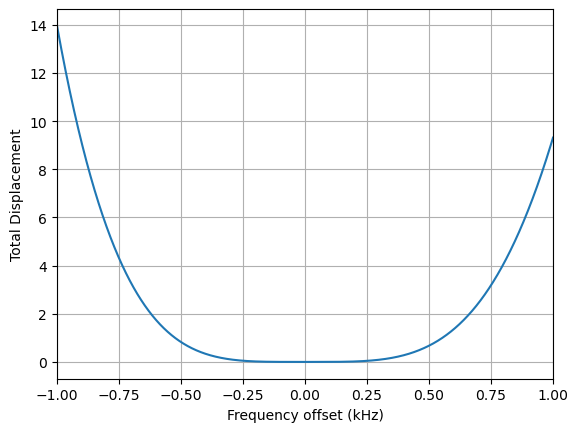

In [18]:
clf()
plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
xlim([-1, 1])
# ylim([0, 100])
xlabel("Frequency offset (kHz)")
ylabel("Total Displacement")
grid()
# display(gcf())

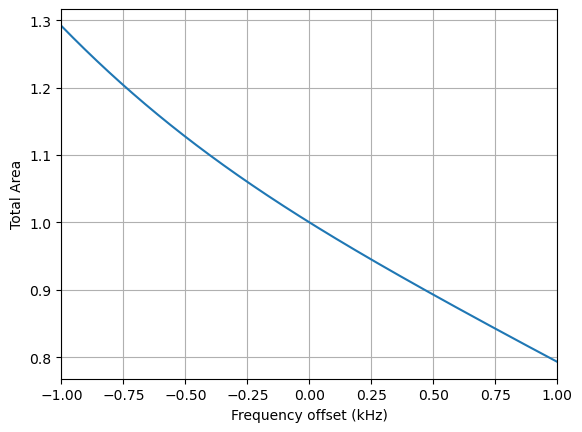

In [19]:
clf()
area0 = Seq.total_area(kern, opt_raw_params, modes)
plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
xlim([-1, 1])
xlabel("Frequency offset (kHz)")
ylabel("Total Area")
grid()
# display(gcf())

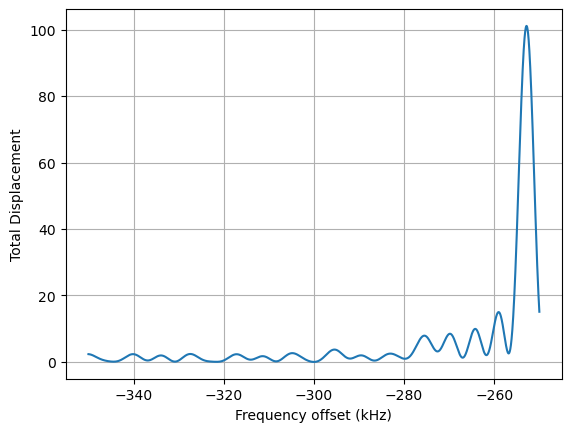

In [20]:
plot_δs2 = [range(-350, -250, 10001);]
clf()
plot(plot_δs2, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs2])
# xlim([-1, 1])
# ylim([0, 100])
xlabel("Frequency offset (kHz)")
ylabel("Total Displacement")
grid()
# display(gcf())

In [21]:
_ion1 = ion1 - (nions + 1) ÷ 2
_ion2 = ion2 - (nions + 1) ÷ 2
solution_set = GoldGates.GateSolutionSet(params=sysparams, XX=Dict("$_ion1:$_ion2"=>GoldGates.XXSolution(opt_raw_params, enclosed_area)))
open("../out/20250722_linear_pm_13_v2.json", "w") do io
    write(io, solution_set, format=:json)
end